In [36]:
import pandas as pd
df = pd.read_csv("datasets/youtube_cleaned.csv")

/var/folders/lv/fm0yr04d2tz77p6w1vl9y72w0000gn/T/ipykernel_41882/2809025955.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("datasets/youtube_cleaned.csv")


In [37]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Apply VADER to raw text column
df['vader_score'] = df['text'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

# Classify sentiment based on compound score
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['vader_score'].apply(classify_sentiment)

# Convert datetime and extract date for trend analysis
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['date'] = df['datetime'].dt.date

df.to_csv('datasets/youtube_with_sentiment.csv', index=False)
print("youtube_with_sentiment.csv")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/harrietmathew/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


youtube_with_sentiment.csv


In [39]:
# Classify strong sentiment
def classify_strong_sentiment(score):
    if score >= 0.6:
        return 'strong_positive'
    elif score <= -0.6:
        return 'strong_negative'
    else:
        return 'other'

df['platform'] = 'YouTube'
df['strong_sentiment'] = df['vader_score'].apply(classify_strong_sentiment)

# Group and summarize
grouped = df.groupby(['platform', 'event'])
summary = grouped.agg(
    avg_sentiment=('vader_score', 'mean'),
    total=('vader_score', 'count'),
    strong_positive=('strong_sentiment', lambda x: (x == 'strong_positive').sum()),
    strong_negative=('strong_sentiment', lambda x: (x == 'strong_negative').sum())
).reset_index()

# Add percentage columns
summary['% Strong Positive (≥ 0.6)'] = (summary['strong_positive'] / summary['total'] * 100).round(1)
summary['% Strong Negative (≤ -0.6)'] = (summary['strong_negative'] / summary['total'] * 100).round(1)

# Final summary table
summary_table = summary[['platform', 'event', 'avg_sentiment', '% Strong Positive (≥ 0.6)', '% Strong Negative (≤ -0.6)']]
summary_table.columns = ['Platform', 'Event', 'Avg. Sentiment', '% Strong Positive (≥ 0.6)', '% Strong Negative (≤ -0.6)']

# Save the summary table
summary_table.to_csv('datasets/youtube_emotional_unity_summary.csv', index=False)
print(summary_table)

  Platform      Event  Avg. Sentiment  % Strong Positive (≥ 0.6)  \
0  YouTube   Olympics        0.084994                       13.6   
1  YouTube  World Cup        0.085420                       10.6   

   % Strong Negative (≤ -0.6)  
0                         5.8  
1                         2.4  


In [40]:
reddit_summary = pd.read_csv('datasets/reddit_emotional_unity_summary.csv')
youtube_summary = pd.read_csv('datasets/youtube_emotional_unity_summary.csv')

combined_summary = pd.concat([reddit_summary, youtube_summary], ignore_index=True)
print(combined_summary)

combined_summary.to_csv('datasets/emotional_unity_combined_summary.csv', index=False)

  Platform      Event  Avg. Sentiment  % Strong Positive (≥ 0.6)  \
0   Reddit   Olympics        0.115646                       18.2   
1   Reddit  World Cup        0.083151                       15.8   
2  YouTube   Olympics        0.084994                       13.6   
3  YouTube  World Cup        0.085420                       10.6   

   % Strong Negative (≤ -0.6)  
0                         7.8  
1                         8.2  
2                         5.8  
3                         2.4  


In [41]:
from nrclex import NRCLex
from collections import Counter
import nltk
nltk.download('punkt')

# Function to extract emotion scores
def extract_emotions(text):
    if pd.isna(text) or not text.strip():
        return {}
    emotion = NRCLex(text)
    return emotion.raw_emotion_scores

# Apply to the cleaned text
df['emotion_scores'] = df['clean_text'].astype(str).apply(extract_emotions)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/harrietmathew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [42]:
emotion_summary = {}

# Group by platform and event (e.g., Reddit - World Cup)
for (platform, event), group in df.groupby(['platform', 'event']):
    emotion_counter = Counter()
    for emotion_dict in group['emotion_scores']:
        emotion_counter.update(emotion_dict)
    
    total = sum(emotion_counter.values())
    proportions = {emotion: round((count / total) * 100, 2) for emotion, count in emotion_counter.items()}
    
    emotion_summary[(platform, event)] = proportions

emotion_df = pd.DataFrame(emotion_summary).fillna(0).T.reset_index()
emotion_df.columns = ['Platform', 'Event'] + [col.capitalize() for col in emotion_df.columns[2:]]

emotion_df.to_csv('datasets/youtube_emotion_lexicon_breakdown.csv', index=False)
print(emotion_df)


  Platform      Event    Joy  Positive  Surprise  Negative  Sadness  Anger  \
0  YouTube   Olympics  10.67     20.60      5.32     13.54     6.87   6.68   
1  YouTube  World Cup  12.26     20.55      4.76     13.30     7.12   6.72   

   Anticipation  Disgust  Fear  Trust  
0         10.56     5.93  7.80  12.03  
1         12.58     3.98  7.37  11.36  


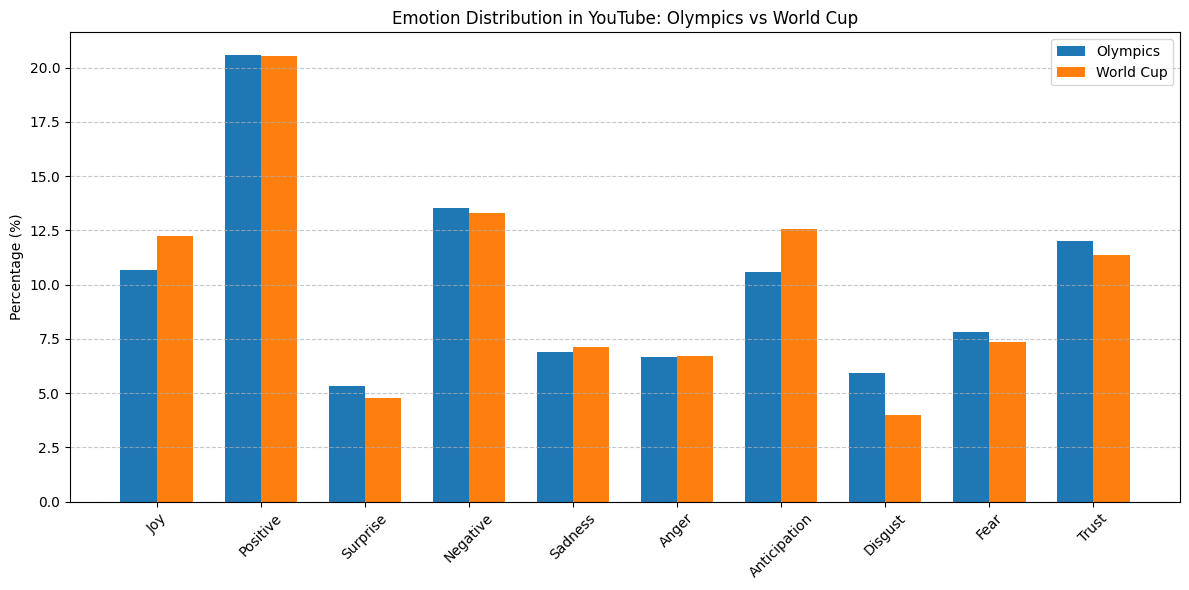

In [43]:
import matplotlib.pyplot as plt

youtube_df = emotion_df[emotion_df['Platform'] == 'YouTube']

emotion_cols = ['Joy', 'Positive', 'Surprise', 'Negative', 'Sadness',
                'Anger', 'Anticipation', 'Disgust', 'Fear', 'Trust']

x = range(len(emotion_cols))
bar_width = 0.35

olympics_vals = youtube_df[youtube_df['Event'] == 'Olympics'][emotion_cols].values.flatten()
worldcup_vals = youtube_df[youtube_df['Event'] == 'World Cup'][emotion_cols].values.flatten()

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar([p - bar_width/2 for p in x], olympics_vals, width=bar_width, label='Olympics')
bars2 = ax.bar([p + bar_width/2 for p in x], worldcup_vals, width=bar_width, label='World Cup')

ax.set_xticks(x)
ax.set_xticklabels(emotion_cols, rotation=45)
ax.set_ylabel('Percentage (%)')
ax.set_title('Emotion Distribution in YouTube: Olympics vs World Cup')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [44]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

df = pd.read_csv('datasets/youtube_with_sentiment.csv')

df['lda_text'] = df['clean_text']
df['strong_sentiment'] = df['vader_score'].apply(classify_strong_sentiment)

def get_topics_from_texts(texts, n_topics=4, n_top_words=10):
    vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
    X = vectorizer.fit_transform(texts)
    
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)

    words = vectorizer.get_feature_names_out()
    topic_keywords = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_keywords.append((f"Topic {topic_idx + 1}", top_words))
    return topic_keywords

for event in ['World Cup', 'Olympics']:
    for sentiment in ['strong_positive', 'strong_negative']:
        subset = df[(df['event'] == event) & (df['strong_sentiment'] == sentiment)]
        subset = subset.dropna(subset=['lda_text'])
        if not subset.empty:
            print(f"\nTop Topics in {sentiment.replace('_', ' ').title()} Comments - {event}")
            topics = get_topics_from_texts(subset['lda_text'])
            for topic, keywords in topics:
                print(f"{topic}: {', '.join(keywords)}")


/var/folders/lv/fm0yr04d2tz77p6w1vl9y72w0000gn/T/ipykernel_41882/1559239527.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('datasets/youtube_with_sentiment.csv')



Top Topics in Strong Positive Comments - World Cup
Topic 1: win, croatia, like, team, france, year, country, dont, respect, better
Topic 2: best, world, cup, messi, argentina, goal, final, fifa, player, win
Topic 3: great, goal, russia, football, beautiful, amazing, time, greatest, game, like
Topic 4: love, song, jungkook, like, life, bts, live, proud, masterpiece, wow

Top Topics in Strong Negative Comments - World Cup
Topic 1: team, fan, game, penalty, bad, didnt, match, ronaldo, final, stupid
Topic 2: world, rigged, cup, goal, messi, penalty, france, argentina, lost, time
Topic 3: country, penalty, racist, dead, win, song, fifa, got, dont, say
Topic 4: world, cup, worst, que, song, russia, war, final, country, qatar

Top Topics in Strong Positive Comments - Olympics
Topic 1: best, olympics, olympic, medal, gold, game, ceremony, team, paris, win
Topic 2: like, great, amazing, people, look, lol, really, bolt, dont, good
Topic 3: love, god, wow, beautiful, greatest, time, jesus, peopl